# Weak SINDy

We aim to perform system identification using the Weak SINDy approach, as described by [MESSENGER, 2020](https://arxiv.org/abs/2005.04339). The method is based on SINDy (Sparse Identification of Nonlinear Dynamical Systems) and is naturally resilient to noise. It achieves this by replacing the pointwise computation of time-series derivatives with derivatives of known test functions through integration by parts. We want to identify a dynamical system from data $x$ collected in a time interval $[a,b]$, in this form

$$
\dot{x}(t) = f(x(t))
$$

We introduce a set of test functions $\psi_k$ in order to rewrite the differential equation in its weak form

$$
\begin{aligned}
&\int_a^b \psi(t) f(x(t)) dt = 
- \int_a^b \dot{\psi}(t)x(t) dt  + \psi(b)x(b) - \psi(a)x(a) 
\end{aligned}
$$

By assumption, $f$ is considered to be a linear combination of basis functions $\phi_j$.

$$
f = \sum_{j=1}^J \omega_j \phi_j
$$

These basis functions $\phi_j$ can be any set of preferabbly orthogonal functions. On the ligth of Weierstrass approximation theorem, we will retain using polynomials avaluated at $x(t_k)$. For compactly supported functions

$$
\psi(t) = \frac{(t-a)^p (b-t)^q}{p^q q^p} \left( 
\frac{p+q}{b-a} \right)^{p+q}
$$

, the differential equation then reads

$$
\int_a^b  \psi(t)  \sum_{j=1}^J \omega_j \phi_j = \int_a^b - \dot{\psi}(t)x(t) dt
$$

Or in the matrix form

$$
\mathbf{Gw}=\mathbf{b}
$$

, with $\mathbf{G}= \langle \phi_j (x), \psi_k \rangle$, and $\mathbf{b} = -\langle x, \dot{\psi}_k \rangle$. The system idenfication problem then reduces to find the optimial sparse coefficients $\mathbf{w}$, in the least square sense. The $R(\cdot)$ is any regularization method, in the following problem we will use $L2$ norm (Tikhonov regularization).

$$
\begin{aligned}
&\min_\mathbf{w}\| \mathbf{G}\mathbf{w} - \mathbf{b} \|^2_2 + \lambda R(\mathbf{w})
\end{aligned}
$$

## Generating data

The Lorenz '63 system is a simplified mathematical model that exhibits chaotic behavior. It was introduced by Edward Lorenz in 1963 to study atmospheric convection. The system consists of three coupled nonlinear ordinary differential equations.

The equations of the Lorenz '63 system are:

$$
\begin{align}
\frac{{dx}}{{dt}} = \sigma(y - x) \\
\frac{{dy}}{{dt}} = x(\rho - z) - y \\
\frac{{dz}}{{dt}} = xy - \beta z \\
\end{align}
$$

where $x$, $y$, and $z$ are the state variables, and $\sigma4, $\rho$, and $\beta$ are the system parameters. Typical values are $\sigma = 10$, $\rho = 28$, and $\beta = \frac{8}{3}$.

In [2]:
import sys
import pathlib
sys.path.append(str(pathlib.Path('/Users/properallan/Documents/github/simulai').resolve()))
from examples.utils.lorenz_solver import lorenz_solver
import numpy as np

dt = 0.005
T_max = 100
rho = 28.0
beta = 8.0 / 3.0
beta_str = '8/3'
sigma = 10.0
n_field = 3

initial_state = np.array([8, -8, 27])[None, :]
data, data_derivative, time = lorenz_solver(
    rho=rho, dt=dt, T=T_max, sigma=sigma,
    initial_state=initial_state,
    beta=beta, beta_str=beta_str,
    data_path='on_memory', solver='RK45'
)

Performing Collocation Derivation.


To facilitate system identification, we divide the dataset into two portions: a training set and a testing set.

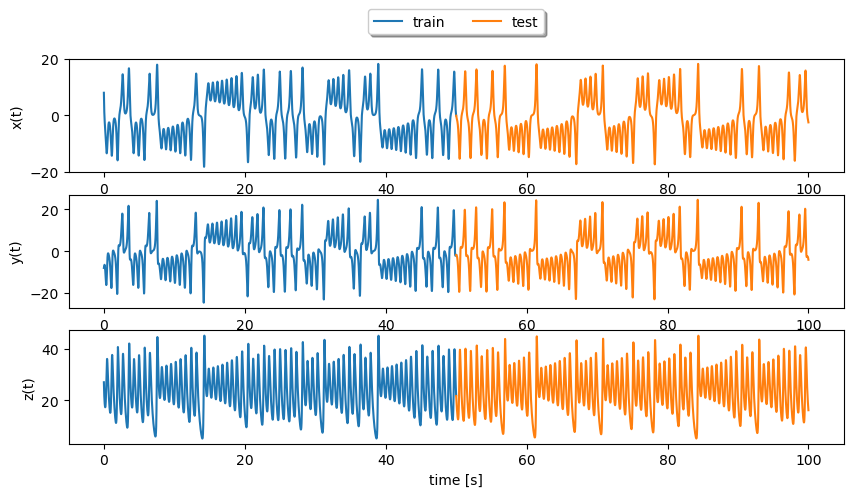

In [3]:
from examples.utils.slice_data import sliceDataAlongAxis
import matplotlib.pyplot as plt

data_train, data_test = sliceDataAlongAxis(data=data, fractions=[0.5,0.5], axis=0)
time_train, time_test = sliceDataAlongAxis(data=time, fractions=[0.5,0.5], axis=0)

fig, ax = plt.subplots(3, 1, figsize=(10, 5))

ax[0].plot(time_train, data_train[:, 0], label='train')
ax[0].plot(time_test, data_test[:, 0], label='test')
ax[1].plot(time_train, data_train[:, 1], label='train')
ax[1].plot(time_test, data_test[:, 1], label='test') 
ax[2].plot(time_train, data_train[:, 2], label='train')
ax[2].plot(time_test, data_test[:, 2], label='test')
ax[0].set_ylabel('x(t)')
ax[1].set_ylabel('y(t)')
ax[2].set_ylabel('z(t)')
ax[2].set_xlabel('time [s]')
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, 3.9),
          fancybox=True, shadow=True, ncol=2)

# Uniform Test Functions

No need for order reduction, so we want to identify the dynamical system on its original coordinates.

In [27]:
from simulai.regression import WeakSINDy
from simulai.math.basis import UniformTestFunction, AdaptiveTestFunction
from pysindy.feature_library.polynomial_library import PolynomialLibrary
from pysindy.optimizers import STLSQ

uniform_test_function = UniformTestFunction(L=1000, overlap=0.5, ghost_cells=0)
basis_function = PolynomialLibrary(degree=2, include_bias=True)
solver = STLSQ(threshold=0.1, alpha=1e-14, max_iter=20)

wsindy_uniform = WeakSINDy(
    solver=solver, 
    test_function=uniform_test_function, 
    feature_library=basis_function
)

wsindy_uniform.fit(input_data=data_train, target_data=time_train)
wsindy_uniform.print(names=['x','y','z'], precision=4)

dx_dt = -10.0000 x + 10.0000 y
dy_dt = 28.0000 x - 1.0000 y - 1.0000 x*z
dz_dt = -2.6667 z + 1.0000 x*y


In this first try we used uniformely sampled test functions.

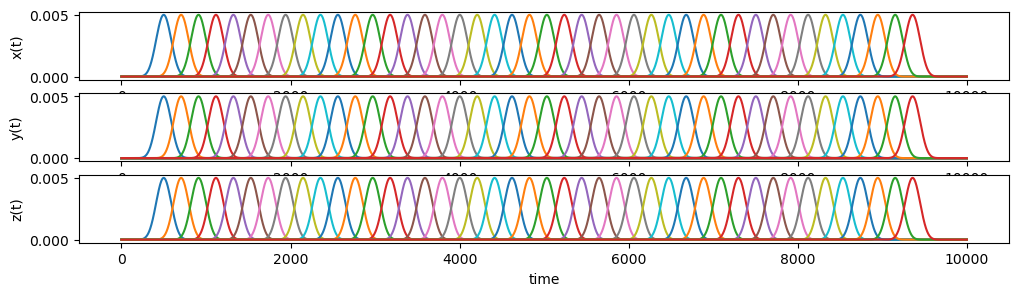

In [42]:
fig, ax = plt.subplots(3, 1, figsize=(12,3))
for i in range(3):
    ax[i].plot(wsindy_uniform.mats[i][0].T)
    
ax[0].set_ylabel('x(t)')
ax[1].set_ylabel('y(t)')
ax[2].set_ylabel('z(t)')
ax[2].set_xlabel('time')
plt.show()

# Adaptive Test Functions

Results of prediction in the test data.

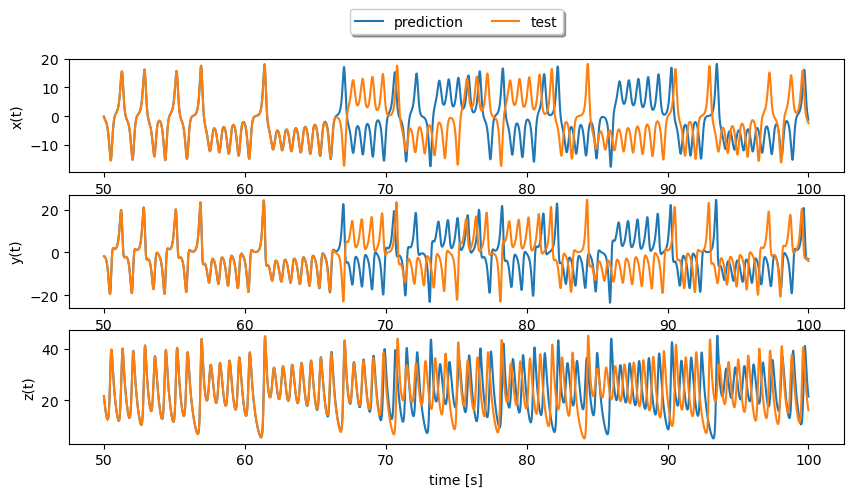

In [36]:
wsindy_uniform_prediction, _ = wsindy_uniform.simulate(x0=data_test[0], t=time_test, integrator='odeint')

fig, ax = plt.subplots(3, 1, figsize=(10, 5))

ax[0].plot(time_test, wsindy_uniform_prediction[:, 0], label='prediction')
ax[0].plot(time_test, data_test[:, 0], label='test')
ax[1].plot(time_test, wsindy_uniform_prediction[:, 1], label='prediction')
ax[1].plot(time_test, data_test[:, 1], label='test') 
ax[2].plot(time_test, wsindy_uniform_prediction[:, 2], label='prediction')
ax[2].plot(time_test, data_test[:, 2], label='test')
ax[0].set_ylabel('x(t)')
ax[1].set_ylabel('y(t)')
ax[2].set_ylabel('z(t)')
ax[2].set_xlabel('time [s]')
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, 3.9),
          fancybox=True, shadow=True, ncol=2)
plt.show()

A similar result could be obtained using an adaptive sampled test function. 

In [100]:
adaptive_test_function = AdaptiveTestFunction(q=16, r_whm = 300, s = 100 , K = 50, p = 16, tau_p = 16)

basis_function = PolynomialLibrary(degree=2, include_bias=True)
solver = STLSQ(threshold=0.1, alpha=1e-14, max_iter=20)

wsindy_adaptive = WeakSINDy(
    solver=solver, 
    test_function=adaptive_test_function, 
    feature_library=basis_function
)

wsindy_adaptive.fit(data_train, time_train)
wsindy_adaptive.print(names=['x','y','z'], precision=4)

dx_dt = -10.0000 x + 10.0000 y
dy_dt = 28.0000 x - 1.0000 y - 1.0000 x*z
dz_dt = -2.6667 z + 1.0000 x*y


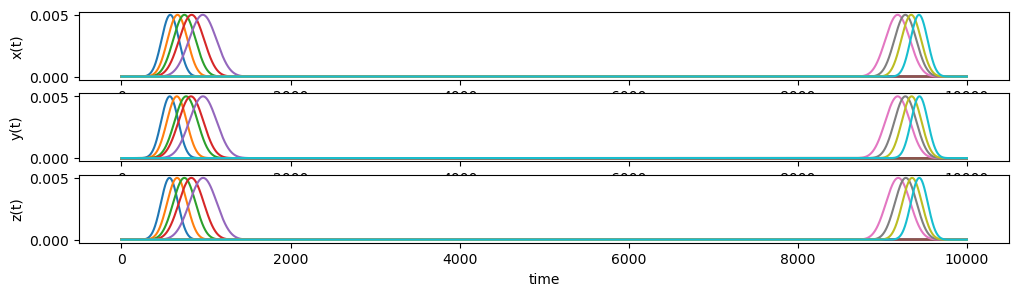

In [101]:
fig, ax = plt.subplots(3, 1, figsize=(12,3))
for i in range(3):
    ax[i].plot(wsindy_adaptive.mats[i][0].T)
    
ax[0].set_ylabel('x(t)')
ax[1].set_ylabel('y(t)')
ax[2].set_ylabel('z(t)')
ax[2].set_xlabel('time')
plt.show()

In [102]:
wsindy_adaptive_prediction, _ = wsindy_adaptive.simulate(x0=data_test[0], t=time_test, integrator='odeint')

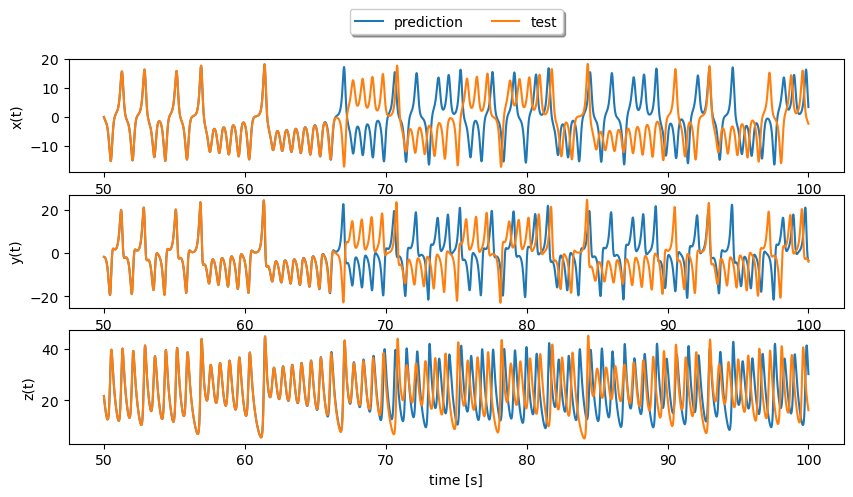

In [103]:
fig, ax = plt.subplots(3, 1, figsize=(10, 5))

ax[0].plot(time_test, wsindy_adaptive_prediction[:, 0], label='prediction')
ax[0].plot(time_test, data_test[:, 0], label='test')
ax[1].plot(time_test, wsindy_adaptive_prediction[:, 1], label='prediction')
ax[1].plot(time_test, data_test[:, 1], label='test') 
ax[2].plot(time_test, wsindy_adaptive_prediction[:, 2], label='prediction')
ax[2].plot(time_test, data_test[:, 2], label='test')
ax[0].set_ylabel('x(t)')
ax[1].set_ylabel('y(t)')
ax[2].set_ylabel('z(t)')
ax[2].set_xlabel('time [s]')
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, 3.9),
          fancybox=True, shadow=True, ncol=2)

# Uniform Multiscale Test Functions

Multiscale test functions uses a FFT (Fast Fourier Transform) to capture the higher relevant frequency and adapt the function support size for each dynamical system coordinate.

In [112]:
from simulai.math.basis import UniformMultiscaleTestFunction
multiscale_test_function = UniformMultiscaleTestFunction(L=4, overlap=0.1, ghost_cells=0)

basis_function = PolynomialLibrary(degree=2, include_bias=True)
solver = STLSQ(threshold=0.1, alpha=1e-14, max_iter=20)

wsindy_multiscale = WeakSINDy(
    solver=solver, 
    test_function=multiscale_test_function, 
    feature_library=basis_function
)

wsindy_multiscale.fit(data_train, time_train)
wsindy_multiscale.print(names=['x','y','z'], precision=4)

insufitient data for multiscale
dx_dt = -10.0000 x + 10.0000 y
dy_dt = 28.0000 x - 1.0000 y - 1.0000 x*z
dz_dt = -2.6667 z + 1.0000 x*y


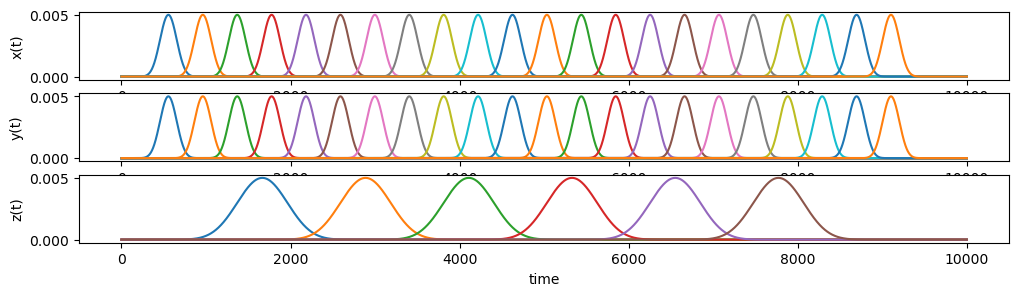

In [113]:
fig, ax = plt.subplots(3, 1, figsize=(12,3))
for i in range(3):
    ax[i].plot(wsindy_multiscale.mats[i][0].T)
    
ax[0].set_ylabel('x(t)')
ax[1].set_ylabel('y(t)')
ax[2].set_ylabel('z(t)')
ax[2].set_xlabel('time')
plt.show()

In [121]:
wsindy_multiscale_prediction, _ = wsindy_multiscale.simulate(x0=data_test[0], t=time_test, integrator='odeint')

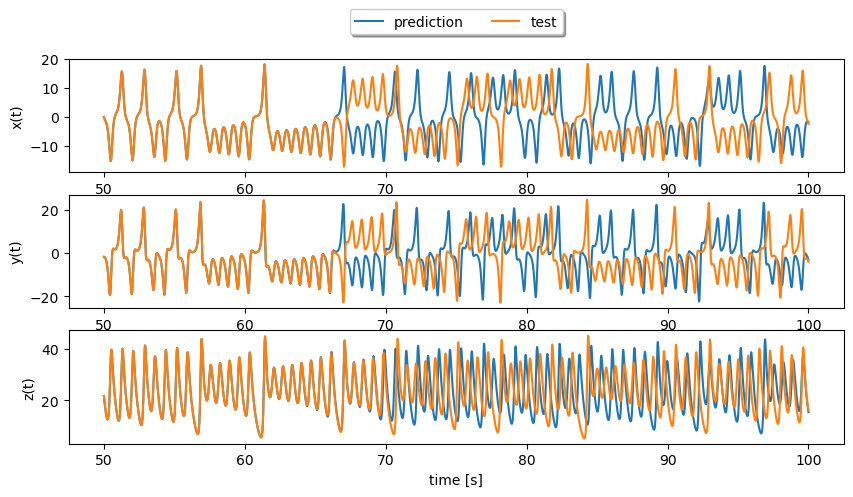

In [122]:
fig, ax = plt.subplots(3, 1, figsize=(10, 5))

ax[0].plot(time_test, wsindy_multiscale_prediction[:, 0], label='prediction')
ax[0].plot(time_test, data_test[:, 0], label='test')
ax[1].plot(time_test, wsindy_multiscale_prediction[:, 1], label='prediction')
ax[1].plot(time_test, data_test[:, 1], label='test') 
ax[2].plot(time_test, wsindy_multiscale_prediction[:, 2], label='prediction')
ax[2].plot(time_test, data_test[:, 2], label='test')
ax[0].set_ylabel('x(t)')
ax[1].set_ylabel('y(t)')
ax[2].set_ylabel('z(t)')
ax[2].set_xlabel('time [s]')
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, 3.9),
          fancybox=True, shadow=True, ncol=2)